In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.sandbox.stats as sandbox_stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA

One-way ANOVA can be seen as a regression model with a **single categorical predictor**. This predictor usually has **2+ categories**. A one-way ANOVA has a single factor with _j_ levels. Each level corresponds to the groups in the independent measures design:

$y_i=b_0+b_1.X_{1,i}+...+b_{j-1,i}+e_i$

H0 = all groups were sampled from populations with identical meand ; no difference between means, i.e. $ \bar{x_1} = \bar{x_2} = \bar{x_3}$

This is the analysis of the variance: _comparing the ratio of systematic variance to unsystematic variance_ using sum of squares (SS), between the groups `SSB` and the variance within the group `SSW`.  
With $SSW + SSB = SST$, we can compute the F statistic:

$$
F=\frac{\frac{SSB}{m-1}}{\frac{SSW}{n-m}}
$$

with `m` the number of groups and `n` the total number of points.  

When F increase, then the variance between the group (SSB) is bigger than within the group (SSW).
We then compare the F statistic to the critical F* using df1 and df2.

the group means are represented as deviations from the grand mean by grouping their coefficients under a single term:
$y_{ij}=\mu_{grand}+\tau_j+\epsilon_{ij}$

One example of one-way ANOVA comparing 3 groups:  

Hypothesis | Scatter from | Sum of squares | Percentage of variation | $R²$
---|---|---|---|---
Null | Grand mean | 17.38 | 100.0% |
Alternative | Group mean | 16.45 | 94.7% |
Difference | - | .93 | 5.3% | 0.053

Of all the variation, 94.7% is the result of variation within the groups, leaving 5.3% of the total variation as the result of differences between the group means.  
**The sum of squares resulting from the treatment and the sum of sqaures within the groups always add up to the total sum of squares.**

Source of variation | Sum of squares | DF | MS | F ratio | P value
---|---|---|---|---|---
Between groups | .93 | 2 | .46 | 5.69 | 0.0039
+ Within groups (replicates, residual)| 16.45 | 202 | 0.081 | 
= Total | 17.38 | 204 |

For the total, there are 205 values and only one parameter (grand mean) estimated, so df=204.  
For the SSW, 3 parameters were fit (the mean of each group), so df = 205 - 3 = 202.  
If the null hypothesis were true, F would be likely to have a value close to 1.

In [2]:
dfn, dfd = 2, 202
F = .46 / .081
p_value= 1 - stats.f(dfn, dfd).cdf(F)
print(f"P values computed from the F ratio distribution: {p_value:.4f}")

P values computed from the F ratio distribution: 0.0040


The low P value means that the differences among group means would be very unlikely if in fact all the population means were equal.  
The low R² means that the differences among group means are only a tiny fraction of the overall variability.

## Practical example of one-way ANOVA

In [3]:
data = pd.read_csv("../data/PlantGrowth.csv", index_col=0)
data.head()

,weight,group
1,4.17,ctrl
2,5.58,ctrl
3,5.18,ctrl
4,6.11,ctrl
5,4.50,ctrl


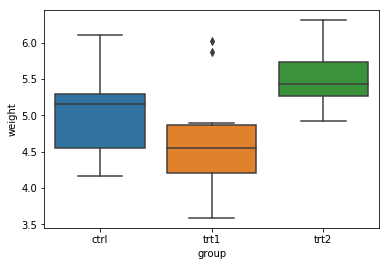

In [4]:
sns.boxplot(x='group', y='weight', data=data);

### Using scipy.stats

In [5]:
k = data['group'].nunique() # number of conditions
N = len(data) # number of total values
m = data.groupby('group').size() # number of values in each group

In [6]:
print(k, N, m)

3 30 group
ctrl    10
trt1    10
trt2    10
dtype: int64


In [7]:
data['group'].unique()

array(['ctrl', 'trt1', 'trt2'], dtype=object)

In [8]:
F, p = stats.f_oneway(data[data['group'] == 'ctrl']['weight'],
                     data[data['group'] == 'trt1']['weight'],
                     data[data['group'] == 'trt2']['weight'])

In [9]:
F, p

(4.846087862380136, 0.0159099583256229)

### Using manual computation

In [10]:
data['SST'] = (data['weight'] - data['weight'].mean())**2

In [11]:
SST = data['SST'].sum() # total sum of squares (grandmean)
SST

14.258429999999999

In [12]:
data['SSW'] = data.groupby('group')['weight'].transform(lambda x: (x - x.mean())**2)
SSW = data['SSW'].sum() # sum of squares within groups (group means)
SSW

10.492089999999997

In [13]:
SSW/SST

0.7358517031678802

In [14]:
SSB = SST - SSW
SSB

3.7663400000000014

In [15]:
SSB/SST

0.26414829683211977

In [16]:
10.492/27

0.3885925925925926

In [17]:
3.766/2

1.883

In [18]:
F_ratio = 1.883/.389
F_ratio

4.840616966580977

In [19]:
dfn, dfd = 2, 27
p_value= stats.f.sf(F, dfn, dfd) # using here the 'survival function 1 - cdf()'
p_value

0.0159099583256229

We then fill the following table and then the ANOVA table:  

Hypothesis | Scatter from | Sum of squares | Percentage of variation | $R²$
---|---|---|---|---
Null | Grand mean | 14.258 | 100.0% |
Alternative | Group mean | 10.492 | 73.59% |
Difference | - | 3.766 | 26.41% | 0.2641  

Source of variation | Sum of squares | DF | MS | F ratio | P value
---|---|---|---|---|---
Between groups | 3.766 | 29-27 = 2 | 1.883 | 4.841 | 0.0159
+ Within groups | 10.492 | N-k = 27 | 0.389 | 
= Total | 14.258 | N-1 (grandmean) = 29 |

#### Effect size
$\eta²$ = R²  
R² measures of much variance is explained by the model.  
R² = SSB / SST

In [20]:
3.766/14.258

0.2641324168887642

Omega squared (ω2) is a measure of effect size, or the degree of association for a population. It is an estimate of **how much variance in the response variables are accounted for by the explanatory variables**. Omega squared is widely viewed as a lesser biased alternative to eta-squared, especially when sample sizes are small. Zero indicates no effect.
$$
\omega² = \frac{SSB-(DF_B * MS_W)}{SST + MS_W}
$$

In [21]:
omega2 = (SSB - (2*.389)) / (SST + .389)
omega2

0.20401804275562346

### statsmodels

In [22]:
model = ols('weight ~ group', data=data).fit() # we use OLS regression
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     4.846
Date:                Thu, 15 Nov 2018   Prob (F-statistic):             0.0159
Time:                        13:23:16   Log-Likelihood:                -26.810
No. Observations:                  30   AIC:                             59.62
Df Residuals:                      27   BIC:                             63.82
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.0320      0.197     25.527      0.000       4.628       5.436
group[T.trt1]    -0.3710      0.279     -1.331      0.194      -0.943       0.201
group[T.trt2]     0.4940      0.279      1.772      0.088      -0.078       1.066
==============================================================================
Omnibus:                        1.835   Durbin-Watson:                   2.704
Prob(Omnibus):                  0.400   Jarque-Bera (JB):                1.406
Skew:                           0.524   Prob(JB):                        0.495
Kurtosis:                       2.835   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
anova_table = sm.stats.anova_lm(model, typ='II')
anova_table

,sum_sq,df,F,PR(>F)
group,3.76634,2.0,4.846088,0.01591
Residual,10.49209,27.0,NaN,NaN


# Two-way ANOVA

The data are divided in two ways because each data point is either from an animal given either an inactive or active treatment (one factor) given for either a short or long duration (second factor). If male and female animals were both included you'd need three-way ANOVA.

Two-way ANOVA simultaneously tests 3 null hypotheses and so computes 3 P values:
1. there is no interaction between the two factors (treatment and duration);
2. the population means are identical for animals given placebo and active treatment (treatment), pooling short+log duration;
3. the population means are identical for animals given a treatment for short vs. long duration (duration).

Source of variation | Sum of squares | DF | MS
---|---|---|---
Interaction | 12896 | 1 | 12896 
+ Between rows | 5764 | 1 | 5764
+ Between columns | 3710 | 1 | 3710
+ Among replicates (residual) | 928 | 8 | 116
= Total | 23298 | 11

# Multiple comparison tests after ANOVA

The goal is to compare every mean with every other mean. The results of Tukey (or more generally Tuker-Kramer test which allows for unequal sample size) include:
- both CIs,
- conclusions about statistical significance 

In [24]:
mult_comp = sm.stats.multicomp.MultiComparison(data['weight'], data['group'])

## Tukey

In [25]:
print(mult_comp.tukeyhsd()) # P values are computed but not displayed

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 ctrl   trt1   -0.371  -1.0621 0.3201 False 
 ctrl   trt2   0.494   -0.1971 1.1851 False 
 trt1   trt2   0.865    0.1739 1.5561  True 
--------------------------------------------


These are multiple comparisons CIs, so the 95% confidence level applies to the entire family of comparisons, rather than to each individual interval. There is a 95% change that all three of these CIs include the true population value, leaving a 5% chance that any one or more of the intervals does not include the population value.  
If a 95% CI for the difference between two means include zero ($H_0$) then the difference is not statistically significant (P>0.05).  
The 5% significance level is a **familywise significance level**, meaning that it applies to the entire set of comparisons. If the null hypothesis is true, there is a 5% chance that one or more of the comparisaons will be statistically significant. The _yes/no_ conclusions apply to each comparison individually.

In [26]:
print(mult_comp.groupstats.groupmean)

[5.032 4.661 5.526]


In [27]:
mult_comp_2 = sm.stats.multicomp.pairwise_tukeyhsd(data['weight'], data['group'])
# Tukey’s Honestly Significant Difference
mult_comp_2.summary()

group1,group2,meandiff,lower,upper,reject
ctrl,trt1,-0.371,-1.0621,0.3201,False
ctrl,trt2,0.494,-0.1971,1.1851,False
trt1,trt2,0.865,0.1739,1.5561,True


In [28]:
np.diff(mult_comp_2.confint) # same CI for all three comparisons (see end of this part), here n=10 in all groups

array([[1.38217336],
       [1.38217336],
       [1.38217336]])

When computing most multiple comparisons tests, the SD for difference between 2 means is not computed from the SDs of those two groups but rather from the pooled SD of all the groups. The margin of error of the CI is computed by multiplying the SE of the difference by a critical value that depends on the choice of test, the number of df, the degree of confidence desired and the number of comparisons:
$$
\bar{y_i} - \bar{y_j} \pm t_{1-\alpha/2}\sqrt{\frac{SSE}{n-k}\left(\frac{1}{n_i}+\frac{1}{n_j}\right)}
$$
and $MSE = SSE/(n-k) = s_p²$ (pooled variance)

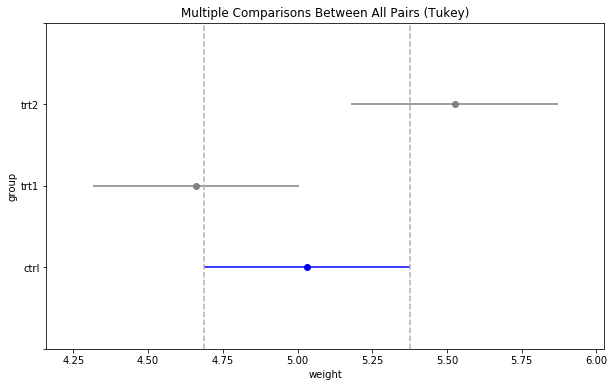

In [29]:
_ = mult_comp_2.plot_simultaneous(comparison_name='ctrl', xlabel='weight', ylabel='group')

## Dunnett's test
Compares the mean of each group to the mean of a control group without comparing the other groups among themselves. The test makes fewer comparisons than Tukey's method, so it generates narrower CIs and has more power to detect differences.

In [30]:
# there is nothing well established in Python, so let's use R
import rpy2.ipython
%load_ext rpy2.ipython

In [31]:
%%R
print(head(data))

This is not working, better to switch to a different notebook dedicated to analyses using R.

## Bonferroni's test
Bonferroni's multiple comparisons test should be used when the experiment design requires comparing only selected pairs of means (different from Tukey -> all vs. all, and Dunnett -> all vs. control).

results = mult_comp.allpairtest(stats.ttest_ind, method='bonf')
results[0]

In [32]:
p_val_adj = .05 / 3
p_val_adj

0.016666666666666666

In [33]:
res = stats.ttest_ind(data[data['group'] == 'ctrl']['weight'],
                     data[data['group'] == 'trt1']['weight'])
res

Ttest_indResult(statistic=1.1912603818487009, pvalue=0.2490231659730067)

In [34]:
res.pvalue <= p_val_adj

False

The individual t-tests that are conducted have to have a p-value less than 0.01667 in order to be considered significant.

In [38]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [41]:
multipletests([.05, 0.3, 0.01], alpha=.05, method='bonferroni')

(array([False, False,  True]),
 array([0.15, 0.9 , 0.03]),
 0.016952427508441503,
 0.016666666666666666)

### allpairtest

In [100]:
mult_comp.allpairtest(stats.ttest_ind, method='bonf')[0]

group1,group2,stat,pval,pval_corr,reject
ctrl,trt1,1.1913,0.249,0.7471,False
ctrl,trt2,-2.134,0.0469,0.1406,False
trt1,trt2,-3.0101,0.0075,0.0226,True


The pairwise.ttest for independent samples in R, as well as the Tukey HSD test in both R and statsmoldels, use the **joint variance across all samples**, while the pairwise ttest calculates the joint variance estimate for each pair of sample separately. _stats.ttest_ind_ just looks at one pair at a time:  

```Rscipt
pairwise.t.test(data$weight, data$group, p.adj = "bonferroni")

data:  data$weight and data$group 

     ctrl  trt1 
trt1 0.583 -    
trt2 0.263 0.013

P value adjustment method: bonferroni
```

## Holm adjustment
The Holm adjustment sequentially compares the lowest p-value with a Type I error rate that is reduced for each consecutive test. In our case, this means that our first p-value is tested at the .05/3 level (.017), second at the .05/2 level (.025), and third at the .05/1 level (.05). This method is generally considered superior to the Bonferroni adjustment.

In [97]:
mult_comp.allpairtest(stats.ttest_ind, method='h')[0]

group1,group2,stat,pval,pval_corr,reject
ctrl,trt1,1.1913,0.249,0.249,False
ctrl,trt2,-2.134,0.0469,0.0937,False
trt1,trt2,-3.0101,0.0075,0.0226,True
